Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Importing Skin Cancer Data
To do: Take necessary actions to read the data
Importing all the important libraries


In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

Mounted at /content/gdrive
Mounted at /content/drive


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load images using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset
Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180


Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
## below are to do tasks
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
## below are to do tasks
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
##Visualize the data
#Todo, create a code to visualize one instance of all the nine classes present in the dataset

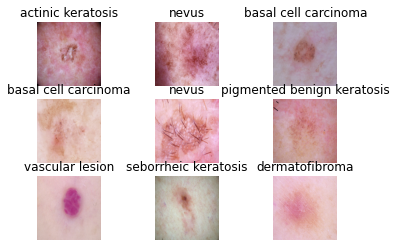

In [10]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
for j in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], j))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, j+1)
        plt.imshow(image[j].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[j]])
        plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
### Your code goes here
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.
num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),    
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

Compile the model.

Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
#loss: Sparse Categorical Crossentropy Calculates the crossentropy loss between labels and predictions.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
#Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 199s 2s/step - loss: 2.0548 - accuracy: 0.2333 - val_loss: 1.8095 - val_accuracy: 0.4004
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6866 - accuracy: 0.3962 - val_loss: 1.6200 - val_accuracy: 0.4295
Epoch 3/20
56/56 [==============================] - 1s 25ms/step - loss: 1.4943 - accuracy: 0.4660 - val_loss: 1.4091 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3673 - accuracy: 0.5195 - val_loss: 1.3889 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 25ms/step - loss: 1.2867 - accuracy: 0.5458 - val_loss: 1.3945 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 1.2421 - accuracy: 0.5625 - val_loss: 1.4438 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 1s 25ms/step - loss: 1.1809 - accuracy: 0.5843 - val_loss: 1.4493 - val_accuracy: 0.5503
Epoch 8/20
56

Visualizing training results

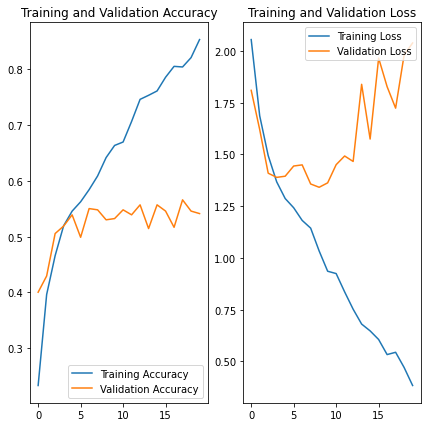

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
Write your findings here
Findings:-
The above model is clearly the case of overfitting and the model doesn't seem to be learning anything from the dataset.
   (1) Training accuracy is very high, but the validation accuracy is around 50%.
   (2) The loss on the training set decrease after each epoch, but in the case of the validation set: it climbs back again after the 5th epoch.

Instead of generalizing and learning real features and general relationships, the model is memorizing the data

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3))  
])

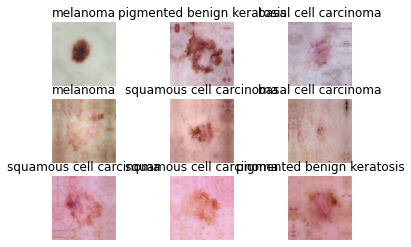

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for img, labels in train_ds.take(1):
    for k in range(9):
        ax=plt.subplot(3,3,k+1)
        plt.imshow(data_augmentation(img)[k].numpy().astype('uint8'))
        plt.title(class_names[labels[k]])
        plt.axis("off")

Todo:
Create the model, compile and train the model

In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip
## Your code goes here
#The Keras sequence class helps create a layer cluster that is linearly stacked into a tf. keras. Model.

num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

Compile the model

In [22]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) ## your training code

Epoch 1/20
56/56 [==============================] - 5s 53ms/step - loss: 2.1591 - accuracy: 0.1892 - val_loss: 1.9709 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.8958 - accuracy: 0.3158 - val_loss: 1.7024 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.6211 - accuracy: 0.4157 - val_loss: 1.4890 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 3s 49ms/step - loss: 1.5294 - accuracy: 0.4676 - val_loss: 1.4546 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.4139 - accuracy: 0.5106 - val_loss: 1.4535 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.3836 - accuracy: 0.5140 - val_loss: 1.3472 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3566 - accuracy: 0.5223 - val_loss: 1.4411 - val_accuracy: 0.4944
Epoch 8/20
56

Visualize the results

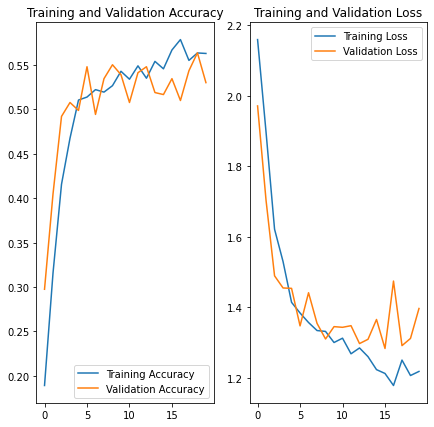

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Findings:-
Use of data augmentation and dropout layer in the above model has reduced the problem of overfitting.

The accuracy of the model has greatly increased alongwith the synchronization of verification accuracy. The loss function is synchronously exhausting for the training and validation data.

Todo: Find the distribution of classes in the training dataset.
Context: In Real life scenarios , datasets can have class imbalance, one class can have proportionately higher number of samples as compared with the other data. Class imbalance will have a detrimental effect on the final model quality. Sanity check is required.  It becomes important to check what is the distribution of classes in the datasets.

In [31]:
## Your code goes here.
## original_df - > path_list, lesion_list
path_list=[]
lesion_list=[]

In [32]:
for k in class_names:
  for l in data_dir_train.glob(k+'/*.jpg'):
    path_list.append(str(l))
    lesion_list.append(k)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2235,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2236,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion
2237,/content/drive/MyDrive/Skin cancer ISIC The In...,vascular lesion


<BarContainer object of 9 artists>

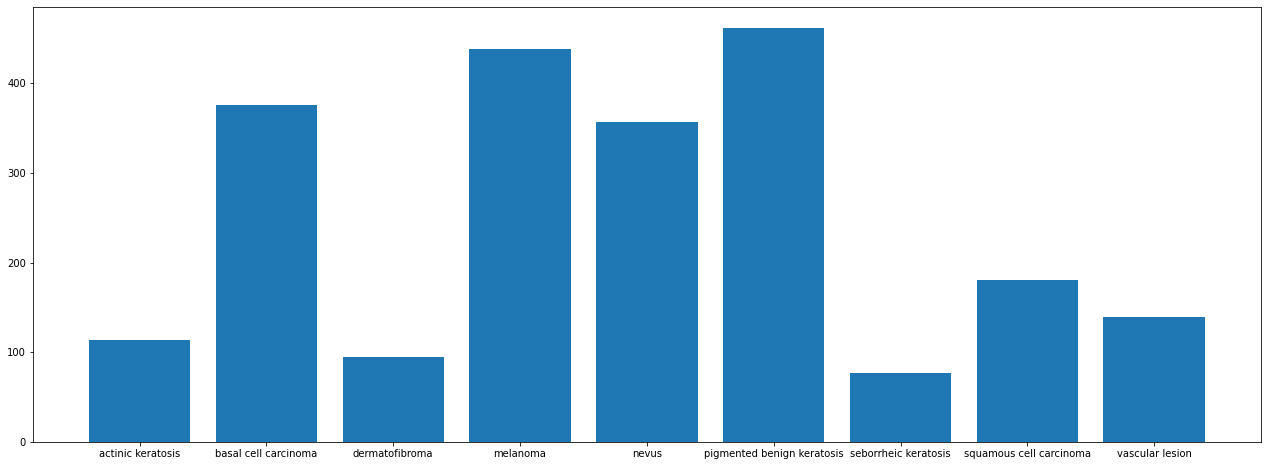

In [33]:
# glob('./Skin cancer ISIC The International Skin Imaging Collaboration/train/*/*')
# './Skin cancer ISIC The International Skin Imaging Collaboration/train\\actinic keratosis\\ISIC_0025780.jpg'
class_count=[]
for k in class_names:
    class_count.append(len(list(data_dir_train.glob(k+'/*.jpg'))))
plt.figure(figsize=(22,8))
plt.bar(class_names,class_count)

Todo: Write your findings here:
- Which class has the least number of samples?

The least number of samples are in seborrheic keratosis.

- Which classes dominate the data in terms proportionate number of samples?

The classes dominating in the data are:-
* pigmented benign
* melanoma
* basal cell carcinoma
* nevus

Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [34]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [36]:
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBCE95EDA90>: 100%|██████████| 500/500 [00:18<00:00, 27.39 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBCE95E44D0>: 100%|██████████| 500/500 [00:18<00:00, 26.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBDDBC97090>: 100%|██████████| 500/500 [00:18<00:00, 27.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FBD0A02C490>: 100%|██████████| 500/500 [01:43<00:00,  4.85 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBCF060EF90>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBCF02EF1D0>: 100%|██████████| 500/500 [00:18<00:00, 27.10 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBCF06CC750>: 100%|██████████| 500/500 [00:43<00:00, 11.57 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBCF19FA6D0>: 100%|██████████| 500/500 [00:18<00:00, 27.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBCF06DCA90>: 100%|██████████| 500/500 [00:18<00:00, 27.13 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500



Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list


['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_eae6adf1-d1a5-4dcd-91b0-bafed79f864a.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_a3605d60-6bae-4ac1-917d-37b9a15daa37.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_54e7b50f-a352-4a65-9d6b-ff61a4ab5348.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_5f394422-737e-47e8-813a-04d95fdd5550.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_e8d77a93-26f5-4506

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [40]:
# 'train/class_name/output/221tews.jpg'.split('/')[-3]

In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [43]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Todo: Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

Todo: Create a training dataset

In [47]:
data_dir_train="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Todo: Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Todo: Create your model (make sure to include normalization)

In [49]:
## your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

Todo: Compile your model (Choose optimizer and loss function appropriately)

In [50]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
epochs = 30
## Your code goes here, use 50 epochs.
history30 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/30
169/169 [==============================] - 41s 226ms/step - loss: 1.9318 - accuracy: 0.2522 - val_loss: 1.5642 - val_accuracy: 0.3890
Epoch 2/30
169/169 [==============================] - 36s 207ms/step - loss: 1.5322 - accuracy: 0.4143 - val_loss: 1.4351 - val_accuracy: 0.4558
Epoch 3/30
169/169 [==============================] - 36s 206ms/step - loss: 1.4532 - accuracy: 0.4414 - val_loss: 1.4230 - val_accuracy: 0.4595
Epoch 4/30
169/169 [==============================] - 35s 204ms/step - loss: 1.4059 - accuracy: 0.4605 - val_loss: 1.3488 - val_accuracy: 0.4840
Epoch 5/30
169/169 [==============================] - 36s 205ms/step - loss: 1.3417 - accuracy: 0.4792 - val_loss: 1.3185 - val_accuracy: 0.4892
Epoch 6/30
169/169 [==============================] - 36s 204ms/step - loss: 1.3274 - accuracy: 0.4850 - val_loss: 1.2775 - val_accuracy: 0.5004
Epoch 7/30
169/169 [==============================] - 36s 204ms/step - loss: 1.2839 - accuracy: 0.5013 - val_loss: 1.2723 - val_ac

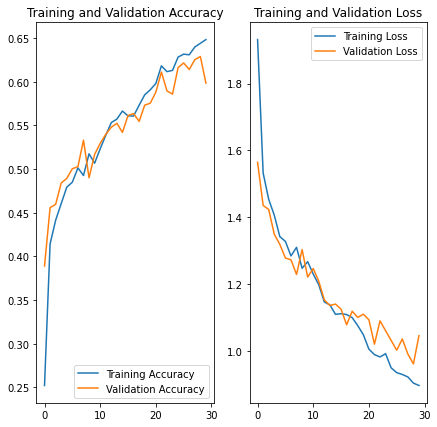

In [53]:
acc = history30.history['accuracy']
val_acc = history30.history['val_accuracy']

loss = history30.history['loss']
val_loss = history30.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Overfitting and underfitting problem was solved and the model was well trained for predictions. In order to improve the performance, Data augmentation, outliers, and class equalization was used and found to be helpful.

Train the model for 50 more epochs

In [55]:
epochs = 50
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/50
169/169 [==============================] - 42s 241ms/step - loss: 0.6403 - accuracy: 0.7472 - val_loss: 1.0195 - val_accuracy: 0.6823
Epoch 2/50
169/169 [==============================] - 39s 227ms/step - loss: 0.6578 - accuracy: 0.7326 - val_loss: 0.9707 - val_accuracy: 0.6845
Epoch 3/50
169/169 [==============================] - 37s 215ms/step - loss: 0.6368 - accuracy: 0.7461 - val_loss: 0.9952 - val_accuracy: 0.6785
Epoch 4/50
169/169 [==============================] - 36s 208ms/step - loss: 0.6200 - accuracy: 0.7591 - val_loss: 1.0332 - val_accuracy: 0.6711
Epoch 5/50
169/169 [==============================] - 36s 206ms/step - loss: 0.6241 - accuracy: 0.7587 - val_loss: 1.0445 - val_accuracy: 0.6719
Epoch 6/50
169/169 [==============================] - 36s 206ms/step - loss: 0.6364 - accuracy: 0.7498 - val_loss: 0.9518 - val_accuracy: 0.6919
Epoch 7/50
169/169 [==============================] - 36s 208ms/step - loss: 0.6244 - accuracy: 0.7500 - val_loss: 0.9472 - val_ac

Visualize the model results for 50 more epochs

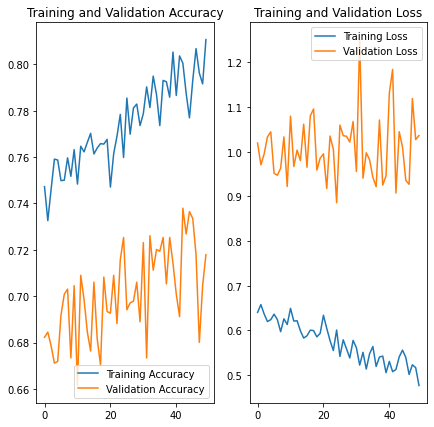

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()